# Optimizing CNN's architecture using genetic algorithms

## Dataset 03: Fashion-Mnist

### 01. Importing Libraries

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Dataset division: Train, test, and validation

In [2]:
# Preparando os datasets e dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

### 03. CNN Architecture

In [3]:
# Definindo a arquitetura da rede neural
class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        # Camada convolucional: 1 canal de entrada (Fashion MNIST), 16 canais de saída, kernel 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Segunda camada convolucional: 16 canais de entrada, 32 de saída, kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Camada totalmente conectada
        self.fc1 = nn.Linear(32 * 7 * 7, n_neurons)  # Tamanho reduzido para 7x7 após pooling
        self.activation = activation_fn  # Função de ativação passada no construtor
        self.fc2 = nn.Linear(n_neurons, 10)  # Fashion MNIST tem 10 classes
    
    def forward(self, x):
        # Passa pela primeira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Passa pela segunda camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Achata a saída para entrar na camada totalmente conectada
        x = x.view(-1, 32 * 7 * 7)  # Redimensiona para batch_size x (32*7*7)
        x = self.fc1(x)
        x = self.activation(x)  # Ativação definida dinamicamente
        x = self.fc2(x)  # Saída final de 10 classes
        return x

### 04. Training and model evaluation function

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Genetic Algorithm

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:35:30<00:00, 1146.02s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [79, 148, 0.09573479886686537, 16]
Parâmetros: {'n_neurons': 79, 'activation_idx': 148, 'learning_rate': 0.09573479886686537, 'batch_size': 16}


### 06. Model Training

#### Model 1 - Not Optimized

In [8]:
# Modelo Não Otimizado
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.05)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|█████████████▌                                                                                                                          | 1/10 [00:39<05:58, 39.79s/época]

Época 1, Loss: 1.0674



Treinamento:  20%|███████████████████████████▏                                                                                                            | 2/10 [01:18<05:14, 39.28s/época]

Época 2, Loss: 0.5571



Treinamento:  30%|████████████████████████████████████████▊                                                                                               | 3/10 [01:56<04:29, 38.50s/época]

Época 3, Loss: 0.4529



Treinamento:  40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [02:33<03:48, 38.08s/época]

Época 4, Loss: 0.3940



Treinamento:  50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [03:11<03:10, 38.12s/época]

Época 5, Loss: 0.3573



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [03:50<02:32, 38.23s/época]

Época 6, Loss: 0.3349



Treinamento:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [04:28<01:54, 38.06s/época]

Época 7, Loss: 0.3187



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [05:07<01:17, 38.61s/época]

Época 8, Loss: 0.3040



Treinamento:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [05:47<00:38, 38.92s/época]

Época 9, Loss: 0.2929



Treinamento: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:25<00:00, 38.54s/época]


Época 10, Loss: 0.2841


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.37batch/s]


#### Model 2 - Not Optimized

In [9]:
# Modelo Não Otimizado
model_non_opt_2 = SimpleNet(n_neurons=20, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|█████████████▌                                                                                                                          | 1/10 [01:01<09:13, 61.54s/época]

Época 1, Loss: 0.7926



Treinamento:  20%|███████████████████████████▏                                                                                                            | 2/10 [01:56<07:42, 57.79s/época]

Época 2, Loss: 0.4250



Treinamento:  30%|████████████████████████████████████████▊                                                                                               | 3/10 [02:53<06:41, 57.30s/época]

Época 3, Loss: 0.3624



Treinamento:  40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [04:12<06:35, 65.97s/época]

Época 4, Loss: 0.3231



Treinamento:  50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [05:23<05:37, 67.59s/época]

Época 5, Loss: 0.2978



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [06:30<04:29, 67.50s/época]

Época 6, Loss: 0.2783



Treinamento:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [07:42<03:26, 68.89s/época]

Época 7, Loss: 0.2643



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [09:21<02:37, 78.70s/época]

Época 8, Loss: 0.2529



Treinamento:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [10:37<01:17, 77.86s/época]

Época 9, Loss: 0.2417



Treinamento: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:44<00:00, 70.46s/época]


Época 10, Loss: 0.2349


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.87batch/s]


#### Model 3 - Not Optimized

In [10]:
# Modelo Não Otimizado
model_non_opt_3 = SimpleNet(n_neurons=150, activation_fn=nn.Sigmoid())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.07)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_3, optimizer_3)

Treinamento:  10%|█████████████▌                                                                                                                          | 1/10 [00:57<08:36, 57.35s/época]

Época 1, Loss: 0.9017



Treinamento:  20%|███████████████████████████▏                                                                                                            | 2/10 [01:41<06:35, 49.39s/época]

Época 2, Loss: 0.4882



Treinamento:  30%|████████████████████████████████████████▊                                                                                               | 3/10 [02:41<06:19, 54.18s/época]

Época 3, Loss: 0.4069



Treinamento:  40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [04:07<06:40, 66.83s/época]

Época 4, Loss: 0.3648



Treinamento:  50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [05:31<06:06, 73.20s/época]

Época 5, Loss: 0.3385



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [07:03<05:17, 79.44s/época]

Época 6, Loss: 0.3139



Treinamento:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [08:22<03:57, 79.22s/época]

Época 7, Loss: 0.2975



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [09:34<02:33, 76.96s/época]

Época 8, Loss: 0.2803



Treinamento:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [10:38<01:12, 72.91s/época]

Época 9, Loss: 0.2677



Treinamento: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:34<00:00, 69.45s/época]


Época 10, Loss: 0.2554


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.13batch/s]


#### Model 4 - Optimized

In [12]:
# Modelo Otimizado
model_opt = SimpleNet(best_params['n_neurons'], activation_fn=nn.ReLU())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|█████████████▌                                                                                                                          | 1/10 [01:00<09:03, 60.41s/época]

Época 1, Loss: 0.5900



Treinamento:  20%|███████████████████████████▏                                                                                                            | 2/10 [02:02<08:09, 61.23s/época]

Época 2, Loss: 0.3584



Treinamento:  30%|████████████████████████████████████████▊                                                                                               | 3/10 [03:05<07:15, 62.20s/época]

Época 3, Loss: 0.3033



Treinamento:  40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [04:15<06:32, 65.38s/época]

Época 4, Loss: 0.2717



Treinamento:  50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [05:25<05:33, 66.78s/época]

Época 5, Loss: 0.2470



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [06:34<04:30, 67.62s/época]

Época 6, Loss: 0.2294



Treinamento:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [07:39<03:20, 66.69s/época]

Época 7, Loss: 0.2118



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [08:55<02:19, 69.86s/época]

Época 8, Loss: 0.1986



Treinamento:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [10:09<01:11, 71.08s/época]

Época 9, Loss: 0.1868



Treinamento: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:22<00:00, 68.27s/época]


Época 10, Loss: 0.1752


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.56batch/s]


### 07. Evaluating Models

In [13]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.8860, Loss = 0.2841, Tempo = 389.38s
Modelo Não Otimizado 2: Acurácia = 0.8983, Loss = 0.2349, Tempo = 710.52s
Modelo Não Otimizado 3: Acurácia = 0.8838, Loss = 0.2554, Tempo = 700.69s
Modelo Otimizado: Acurácia = 0.9108, Loss = 0.1752, Tempo = 689.62s


| Model                    | Accuracy (%) | Training Time (s) |
|--------------------------|--------------|-------------------|
| Model 1 - Non Optimized  |     88,60    |      389,38       |
| Model 2 - Non Optimized  |     89,83    |      710,52       |
| Model 3 - Non Optimized  |     88,38    |      700,69       |
| Model 4 - Optimized      |     91,08    |      689,02       |

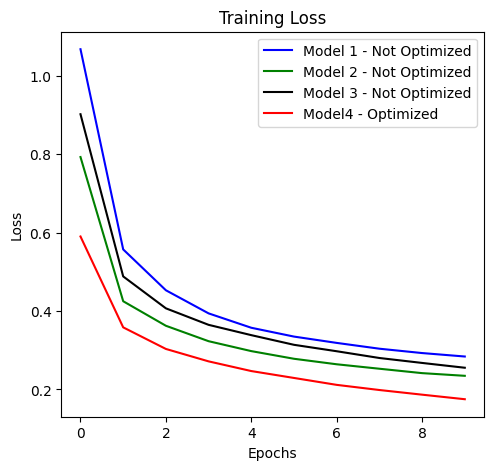

In [14]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Model 1 - Not Optimized', color='blue')
plt.plot(train_losses_non_opt_2, label='Model 2 - Not Optimized', color='green')
plt.plot(train_losses_non_opt_3, label='Model 3 - Not Optimized', color='black')
plt.plot(train_losses_opt, label='Model4 - Optimized', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

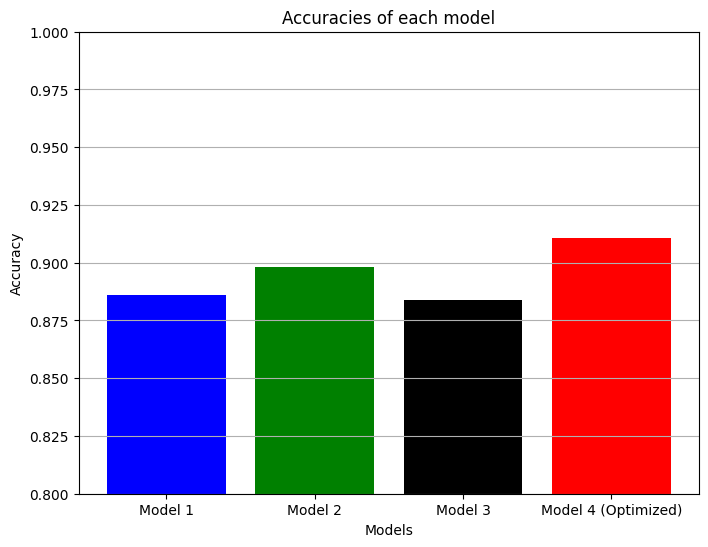

In [18]:
# Acuracias
final_accuracies = [accuracy_non_opt_1, accuracy_non_opt_2, accuracy_non_opt_3, accuracy_opt]

# Nomes dos modelos
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4 (Optimized)']

# Configuração do gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, final_accuracies, color=['blue', 'green', 'black', 'red'])
# Configurações do gráfico
plt.ylim([0.8, 1.00])  # Ajuste o limite do eixo Y para destacar as diferenças pequenas
plt.title('Accuracies of each model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')

plt.show()

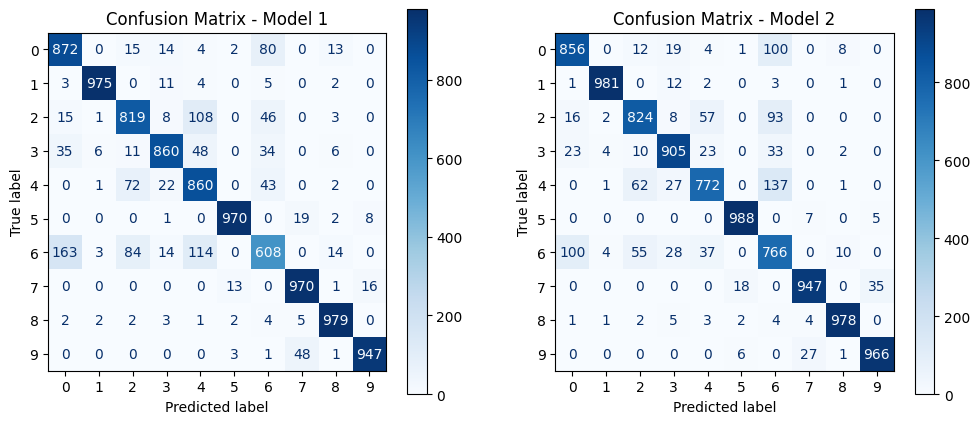

In [19]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 2')

plt.show()

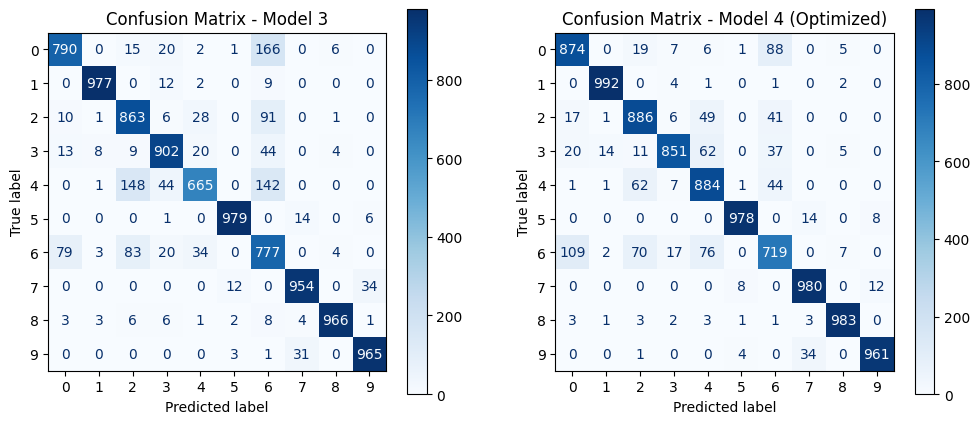

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 4 (Optimized)')

plt.show()